In [1]:
import requests
from bs4 import BeautifulSoup
import re
import time
from datetime import date, timedelta, datetime
import csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso, SGDRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.svm import SVR

In [59]:
# import sys
# !conda install --yes --prefix {sys.prefix} -c conda-forge pymorphy2

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Dev\anaconda3

  added / updated specs:
    - pymorphy2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.9.0               |   py39hcbf5309_1         968 KB  conda-forge
    dawg-python-0.7.2          |     pyhd8ed1ab_0          12 KB  conda-forge
    docopt-0.6.2               |             py_1          14 KB  conda-forge
    pymorphy2-0.9.1            |     pyhd8ed1ab_0          44 KB  conda-forge
    pymorphy2-dicts-ru-2.4.417127.4579844|     pyhd8ed1ab_0         7.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.1 MB

The following NEW packages will be INSTALLED:

  dawg-python        conda-forge/noarch::dawg-python-0.7.2-pyhd8ed1ab_0
  docopt             conda-forge/noarch::docopt-0.6.2-py_1
 

In [5]:
import pymorphy2

Будем парсить сайт https://ria.ru - зададим стартовые URL, с которых начнется поиск, также зададим, что будут участвовать в поиске новости, опубликованные в течении прошлых 10 дней. Сначала с помощью функции get_parsing_urls() получим спсиок неповтоярющихся URL, затем с каждого URL функцией get_article_from_url() получим текст новости, количество просмотров, лайков, дизлайков и дату публикации: 

In [10]:
start_dt = date.today()
end_dt = start_dt + timedelta(-10)
start_dt_url = start_dt.strftime('%Y%m%d')
date_url_list = []

for n in range(int((start_dt - end_dt).days) + 1):
    date_url_list.append((end_dt + timedelta(n)).strftime('%Y%m%d'))


def get_parsing_urls():
    url_more_list = []
    for date_url in date_url_list:
        url = f'https://ria.ru/services/lenta/more.html?id=1821313755&date={date_url}T000000&onedayonly=1&articlemask=lenta_common'
        url_more_list.append(url)

    url_list = ['https://ria.ru/',
                'https://ria.ru/politics/',
                'https://ria.ru/society/',
                'https://ria.ru/economy/',
                'https://ria.ru/world/',
                'https://ria.ru/incidents/',
                'https://ria.ru/science/',
                'https://ria.ru/culture/',
                'https://ria.ru/religion/',
                'https://ria.ru/tourism/',
                'https://ria.ru/export/rss2/archive/index.xml',
                'https://ria.ru/archive/']

    url_list.extend(url_more_list)
    url_start_list = url_list.copy()
    url_set = set()
    url_set.update(url_list)

    for url in url_list:
        counter = 0
        response = requests.get(url)
        time.sleep(0.3)
        result = re.finditer(r'(https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-]).html',
                             response.text)
        for grp in result:
            if grp.group(0).find('ria.ru') > -1:
                url_set.add(grp.group(0))
                url_list.append(grp.group(0))
                counter += 1
        url_list = list(set(url_list))
        print(f'Обработано: {counter} URL')

    for start_url in url_start_list:
        url_set.discard(start_url)

    print(f'Длина списка URL: {len(url_set)}')
    return url_set


def get_article_from_url(parse_url):
    result_dict = {}

    response = requests.get(parse_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    try:
        article_body = soup.find_all('div', class_="article__text")
        article_text = ''

        for divs in article_body:
            temp_str = re.sub(r'(<a[a-zA-Z\d\-\.\:\@\?\=\_\/\"\s]*\">)', '', str(divs), count=0, flags=0)    #\"_blank
            temp_str = re.sub(r'<strong.*strong>', '', temp_str, count=0, flags=0)
            clean_str = temp_str.replace('<div class="article__text">', '').replace('</div>', '').replace('</a>', '').replace('  ', ' ')
            article_text += clean_str + ' '

        article_id = soup.find('div', class_='share m-header')['data-id']
        article_date = soup.find('div', class_='article__info-date').find('a').contents[0]
    except (TypeError, AttributeError):
        return -1

    metrics_url = f'https://ria.ru/services/dynamics/{start_dt_url}/{article_id}.html'

    response = requests.get(metrics_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    article_seen = 0
    article_likes = 0
    article_dislikes = 0
    try:
        article_seen = soup.find('span', class_='statistic__item m-views').contents[1]
        article_likes = soup.find('a', class_='emoji-item m-type-s1 m-active').find('span', class_='m-value').contents[0]
        article_dislikes = soup.find('a', class_='emoji-item m-type-s6 m-active').find('span', class_='m-value').contents[0]
    except AttributeError:
        pass

    result_dict['article_text'] = article_text
    result_dict['article_seen'] = article_seen
    result_dict['article_likes'] = article_likes
    result_dict['article_dislikes'] = article_dislikes
    result_dict['article_date'] = article_date
    return result_dict if len(article_text) > 0 else -1

Сохраним все данные в CSV файл для дальнейшей работы:

In [11]:
with open('ria_news.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    urls_parsing_list = list(get_parsing_urls())
    urls_parsing_count = len(urls_parsing_list)
    for index, parsing_url in enumerate(urls_parsing_list):
        print(f'Обрабатываем {round((index + 1) * 100.0 / urls_parsing_count, 2)}% URL: {parsing_url}')
        result = get_article_from_url(parsing_url)
        if isinstance(result, dict):
            writer.writerow(result.values())

Обработано: 106 URL
Обработано: 64 URL
Обработано: 40 URL
Обработано: 40 URL
Обработано: 64 URL
Обработано: 64 URL
Обработано: 126 URL
Обработано: 202 URL
Обработано: 155 URL
Обработано: 168 URL
Обработано: 200 URL
Обработано: 64 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 60 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 36 URL
Обработано: 36 URL
Обработано: 27 URL
Обработано: 27 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 32 URL
Обработано: 32 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 33 URL
Обработано: 29 URL
Обработано: 29 URL
Обработано: 27 URL
Обработано: 27 URL
Обработано: 30 URL
Обработано: 30 URL
Обработано: 41 URL
Обработано: 41 URL
Обработано: 41 URL
Обработано: 41 URL
Обработано: 41 URL
Обработано: 41 URL
Обработано: 33 URL
Обрабо

Обработано 773 URL, результат сохранен в файл ria_news.csv, будем работать с ним.

In [43]:
df = pd.read_csv('ria_news.csv', sep=',')

In [44]:
df.shape

(664, 5)

Итого имеем данные из 664 новостей 

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   article_text      664 non-null    object
 1   article_seen      664 non-null    int64 
 2   article_likes     664 non-null    int64 
 3   article_dislikes  664 non-null    int64 
 4   article_date      664 non-null    object
dtypes: int64(3), object(2)
memory usage: 26.1+ KB


In [46]:
df.isnull().sum()

article_text        0
article_seen        0
article_likes       0
article_dislikes    0
article_date        0
dtype: int64

Пропусков в данных нет - они были отброшены парсером при скачивании текстов статей. Имеем три непрерывные переменные, полученные из параметров статей - количество просмотров, количество лайков и дизлайков. Анализировать будем количество просмотров.

In [47]:
df.head()

,article_text,article_seen,article_likes,article_dislikes,article_date
0,Ученые ВятГУ изучили влияние тренировочного пр...,1031,18,0,09:00 04.10.2022
1,Белый дом отказался комментировать получение э...,48893,19,1,22:43 26.09.2022
2,Мусульмане отмечают одно из главных событий ис...,2447,47,63,14:16 31.07.2020
3,"В четверг стало известно, что в пятницу 30 сен...",46679,39,9,23:21 29.09.2022
4,США не исключают возможности поставок Украине ...,46438,51,31,22:51 30.09.2022


In [48]:
df.describe()

,article_seen,article_likes,article_dislikes
count,664.000000,664.000000,664.000000
mean,19673.951807,115.631024,24.963855
std,34184.580523,228.339044,162.267972
min,17.000000,0.000000,0.000000
25%,1707.250000,11.750000,2.000000
50%,7050.500000,37.000000,6.000000
75%,33107.750000,124.750000,15.000000
max,368512.000000,3252.000000,3678.000000


Загружаем список стоп-слов для русского языка:

In [49]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rpure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
word_tokenizer = nltk.WordPunctTokenizer()

In [51]:
for index, row in df.iterrows():
    df.loc[index, ('article_date')] = df.loc[index, ('article_date')].split(' ')[1]

In [52]:
df['date_diff'] = 0

In [53]:
end_date = datetime.strptime('04.10.2022', '%d.%m.%Y')
for index, row in df.iterrows():
    current_date = datetime.strptime(df.loc[index, ('article_date')], '%d.%m.%Y')
    delta = end_date - current_date
    df.loc[index, ('date_diff')] = delta.days + 1

Проводим лемматизацию и токенизацию текста:

In [55]:
morph = pymorphy2.MorphAnalyzer()

In [56]:
df['lemmed_text'] = ''

In [57]:
for index, row in df.iterrows():
    text_lower = df.loc[index, ('article_text')].lower()
    tokens = word_tokenizer.tokenize(text_lower)
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words)]
    text_lemmatized = [morph.parse(x)[0].normal_form for x in tokens]
    df.loc[index, ('lemmed_text')] = ' '.join(text_lemmatized)

In [59]:
df_normalized = df.drop(columns=['article_text','article_seen','article_dislikes','date_diff','article_likes','article_date'], axis=1)

Итого имеем датасет для построения модели:

In [60]:
df_normalized.head()

,seen_mean,likes_mean,dislikes_mean,lemmed_text
0,1031,18,0,учёный вятгу изучить влияние тренировочный про...
1,48893,19,1,белый дом отказаться комментировать получение ...
2,2447,47,63,мусульманин отмечать один главный событие исла...
3,46679,39,9,четверг стать известно пятница 30 сентябрь кре...
4,46438,51,31,сша исключать возможность поставка украина тан...


Разбиваем датасет на тренировочный и тестовый:

In [62]:
X = df_normalized['lemmed_text'].values.tolist()
y = np.log(df['seen_mean'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=127)

Подберем оптимальные параметры для количества слов, долей слов, которые встречаются слишком редко или слишком часто:

In [77]:
featurerange_list=np.arange(start=40, stop=44, step=1)
maxdf_list=np.arange(start=0.7, stop=0.9, step=0.1)
mindf_list=np.arange(start=0.01, stop=0.09, step=0.02)
for features in featurerange_list:
    for mindf in mindf_list:
        for maxdf in maxdf_list:
            try:
                vectorizer = TfidfVectorizer(max_features=features, norm=None, max_df = maxdf, min_df = mindf) #, stop_words=['это','также','который','такой','украинский']
                vectorizer.fit(train_X)
                train_X_IDF = vectorizer.fit_transform(train_X)
                test_X_IDF  = vectorizer.transform(test_X)
                print(f'Features: {features} mindf: {mindf} maxdf: {maxdf}')
                print('Метрики LinearRegression:')
                lin_reg = LinearRegression()
                model_scorer(lin_reg, train_X_IDF, train_y, test_X_IDF, test_y)

                print('Метрики RidgeCV:')
                ridge = RidgeCV()
                model_scorer(ridge, train_X_IDF, train_y, test_X_IDF, test_y)

                print('Метрики LassoCV:')
                lasso = LassoCV()
                model_scorer(lasso, train_X_IDF, train_y, test_X_IDF, test_y)

                print('Метрики ElasticNetCV:')
                elastic = ElasticNetCV()
                model_scorer(lin_reg, train_X_IDF, train_y, test_X_IDF, test_y)
            except Exception as err:
                print(str(err))

Features: 40 mindf: 0.01 maxdf: 0.7
Метрики LinearRegression:
   MAE: 1.4459963448660345
   MSE: 3.0210187184591146
   RMSE: 1.7381077982849955
   R2: 0.21051592156007903
 
Метрики RidgeCV:
   MAE: 1.4459406600130125
   MSE: 3.020443842086913
   RMSE: 1.7379424162172097
   R2: 0.21066615424157542
 
Метрики LassoCV:
   MAE: 1.5668351940604845
   MSE: 3.411854837127354
   RMSE: 1.847120688294989
   R2: 0.10837855608052571
 
Метрики ElasticNetCV:
   MAE: 1.4459963448660345
   MSE: 3.0210187184591146
   RMSE: 1.7381077982849955
   R2: 0.21051592156007903
 
Features: 40 mindf: 0.01 maxdf: 0.7999999999999999
Метрики LinearRegression:
   MAE: 1.4459963448660345
   MSE: 3.0210187184591146
   RMSE: 1.7381077982849955
   R2: 0.21051592156007903
 
Метрики RidgeCV:
   MAE: 1.4459406600130125
   MSE: 3.020443842086913
   RMSE: 1.7379424162172097
   R2: 0.21066615424157542
 
Метрики LassoCV:
   MAE: 1.5668351940604845
   MSE: 3.411854837127354
   RMSE: 1.847120688294989
   R2: 0.10837855608052571
 


   MAE: 1.5668351940604845
   MSE: 3.411854837127354
   RMSE: 1.847120688294989
   R2: 0.10837855608052571
 
Метрики ElasticNetCV:
   MAE: 1.4520189144664069
   MSE: 3.0186489712185214
   RMSE: 1.7374259613631085
   R2: 0.21113520859227908
 
Features: 41 mindf: 0.03 maxdf: 0.7
Метрики LinearRegression:
   MAE: 1.4520189144664069
   MSE: 3.0186489712185214
   RMSE: 1.7374259613631085
   R2: 0.21113520859227908
 
Метрики RidgeCV:
   MAE: 1.4518429021714268
   MSE: 3.0179122940588536
   RMSE: 1.7372139459660267
   R2: 0.21132772474087314
 
Метрики LassoCV:
   MAE: 1.5668351940604845
   MSE: 3.411854837127354
   RMSE: 1.847120688294989
   R2: 0.10837855608052571
 
Метрики ElasticNetCV:
   MAE: 1.4520189144664069
   MSE: 3.0186489712185214
   RMSE: 1.7374259613631085
   R2: 0.21113520859227908
 
Features: 41 mindf: 0.03 maxdf: 0.7999999999999999
Метрики LinearRegression:
   MAE: 1.4520189144664069
   MSE: 3.0186489712185214
   RMSE: 1.7374259613631085
   R2: 0.21113520859227908
 
Метрики Ri

   MAE: 1.452066234156525
   MSE: 3.017857103228155
   RMSE: 1.7371980610247513
   R2: 0.21134214778361893
 
Метрики RidgeCV:
   MAE: 1.4518862049057408
   MSE: 3.01713164830219
   RMSE: 1.736989248182668
   R2: 0.21153173122121094
 
Метрики LassoCV:
   MAE: 1.5668351940604845
   MSE: 3.411854837127354
   RMSE: 1.847120688294989
   R2: 0.10837855608052571
 
Метрики ElasticNetCV:
   MAE: 1.452066234156525
   MSE: 3.017857103228155
   RMSE: 1.7371980610247513
   R2: 0.21134214778361893
 
Features: 42 mindf: 0.049999999999999996 maxdf: 0.7
Метрики LinearRegression:
   MAE: 1.4522992409591227
   MSE: 3.0246208171537594
   RMSE: 1.7391437022724026
   R2: 0.20957458360973313
 
Метрики RidgeCV:
   MAE: 1.4521202190947446
   MSE: 3.023853785948415
   RMSE: 1.7389231685006716
   R2: 0.20977503219371096
 
Метрики LassoCV:
   MAE: 1.5668351816891641
   MSE: 3.4118548204330468
   RMSE: 1.8471206837759808
   R2: 0.10837856044325589
 
Метрики ElasticNetCV:
   MAE: 1.4522992409591227
   MSE: 3.024620

   MAE: 1.5668351816891641
   MSE: 3.4118548204330468
   RMSE: 1.8471206837759808
   R2: 0.10837856044325589
 
Метрики ElasticNetCV:
   MAE: 1.4523008132557393
   MSE: 3.024551545816557
   RMSE: 1.7391237868008582
   R2: 0.20959268631710115
 
Features: 43 mindf: 0.049999999999999996 maxdf: 0.8999999999999999
Метрики LinearRegression:
   MAE: 1.4523008132557393
   MSE: 3.024551545816557
   RMSE: 1.7391237868008582
   R2: 0.20959268631710115
 
Метрики RidgeCV:
   MAE: 1.4521214177905597
   MSE: 3.0237984969919487
   RMSE: 1.738907270958388
   R2: 0.20978948087970462
 
Метрики LassoCV:
   MAE: 1.5668351816891641
   MSE: 3.4118548204330468
   RMSE: 1.8471206837759808
   R2: 0.10837856044325589
 
Метрики ElasticNetCV:
   MAE: 1.4523008132557393
   MSE: 3.024551545816557
   RMSE: 1.7391237868008582
   R2: 0.20959268631710115
 
Features: 43 mindf: 0.06999999999999999 maxdf: 0.7
Метрики LinearRegression:
   MAE: 1.4523008132557393
   MSE: 3.024551545816557
   RMSE: 1.7391237868008582
   R2: 0.

Проводим веткоризацию на оптимальных параметрах:

In [108]:
vectorizer = TfidfVectorizer(max_features=42, norm=None, max_df = 0.8, min_df = 0.01)
vectorizer.fit(train_X)

TfidfVectorizer(max_df=0.8, max_features=42, min_df=0.01, norm=None)

Получаем список самых часто встречающися слов:

In [118]:
word_list = vectorizer.get_feature_names_out()

In [110]:
train_X_IDF = vectorizer.fit_transform(train_X)
test_X_IDF  = vectorizer.transform(test_X)

In [111]:
def model_scorer(model, xtr, ytr, xtst, ytst):
    model.fit(xtr, ytr)
    predict = model.predict(xtst)
    mae = metrics.mean_absolute_error(ytst, predict)
    mse = metrics.mean_squared_error(ytst, predict)
    rmse = np.sqrt(metrics.mean_squared_error(ytst, predict))
    r2 = metrics.r2_score(ytst, predict)

    print(f'   MAE: {mae}')
    print(f'   MSE: {mse}')
    print(f'   RMSE: {rmse}')
    print(f'   R2: {r2}')
    print(f' ')

Проводим регуляризацию:

In [113]:
print('Метрики RidgeCV:')
ridge = RidgeCV(alphas=[0.001,0.01,1,10])
model_scorer(ridge, train_X_IDF, train_y, test_X_IDF, test_y)

print('Метрики LassoCV:')
alphavec = 10**np.linspace(-2,2,200)
lasso = LassoCV(alphas = alphavec, cv=5)
model_scorer(lasso, train_X_IDF, train_y, test_X_IDF, test_y)

print('Метрики ElasticNetCV:')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
elastic = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
model_scorer(lin_reg, train_X_IDF, train_y, test_X_IDF, test_y)

Метрики RidgeCV:
   MAE: 1.4518862049057408
   MSE: 3.01713164830219
   RMSE: 1.736989248182668
   R2: 0.21153173122121094
 
Метрики LassoCV:
   MAE: 1.5673161563923894
   MSE: 3.413040640423645
   RMSE: 1.8474416473663369
   R2: 0.10806866961181139
 
Метрики ElasticNetCV:
   MAE: 1.452066234156525
   MSE: 3.017857103228155
   RMSE: 1.7371980610247513
   R2: 0.21134214778361893
 


In [115]:
ridge = RidgeCV(alphas=[0.001,0.01,1,10])
ridge.fit(train_X_IDF, train_y)

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e+00, 1.e+01]))

Получаем список коэффициентов регрессии:

In [119]:
reg_coef = ridge.coef_

Визуализируем коэффициенты регрессии для списка самых часто встречающихся слов:

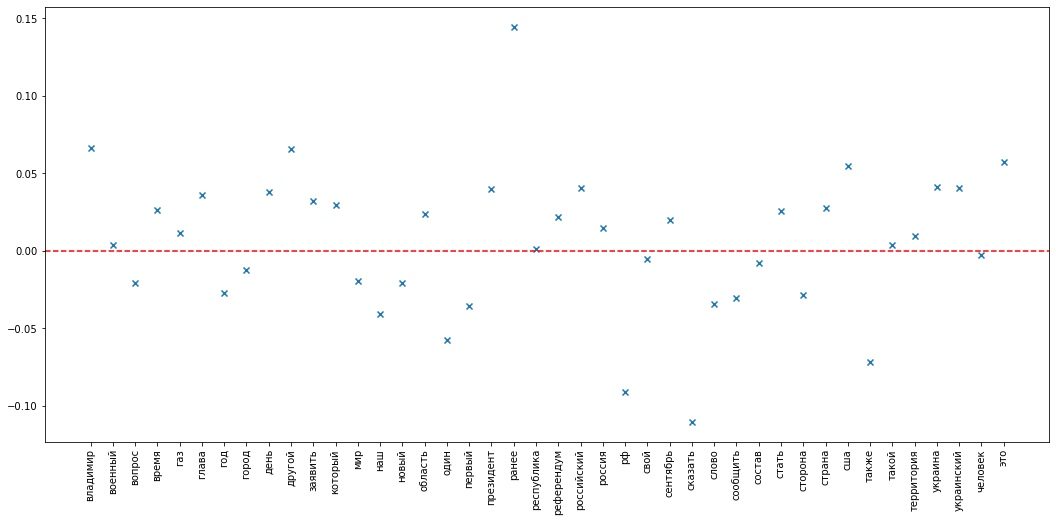

In [129]:
plt.figure(figsize = (18,8))
ax = plt.scatter(x=word_list, y=reg_coef, marker='x')
plt.axhline(0, linestyle='dashed', color='r')
plt.xticks(rotation=90)
plt.show();

График визуализирует плохое прилегание модели к данным (R2 = 0.21), вероятно, что для улучшения качества предсказания нужно анализировать новости одной предметной области, например, новости экономики, полученные новости слишком разноплановы, чем объясняется плохое качество модели.